# Exploring South Bighorn Elk Migration Routes

This notebook explores the South Bighorn herd migration routes dataset - perfect for Area 048 predictions!

In [62]:
import sys
from pathlib import Path

# Add project root to Python path so we can import src modules
# This works whether the notebook is run from project root or notebooks/ directory
current_dir = Path().resolve()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from src.data.hunt_areas import load_area_048_shapefile

# Set up paths
DATA_DIR = Path("../data/raw")
BIGHORN_FILE = DATA_DIR / "elk_southern_bighorn" / "Elk_WY_Bighorn_South_Routes_Ver1_2020.shp"

print("Loading South Bighorn migration routes...")
print(f"File exists: {BIGHORN_FILE.exists()}")

# Load Area 048 polygon
print("\nLoading Area 048 hunt area boundary...")
area_048_gdf = load_area_048_shapefile()
if area_048_gdf is not None:
    # Convert to WGS84 if needed
    if area_048_gdf.crs != 'EPSG:4326':
        area_048_gdf = area_048_gdf.to_crs('EPSG:4326')
    area_048_polygon = area_048_gdf.geometry.iloc[0]
    area_048_center = area_048_gdf.geometry.centroid.iloc[0]
    area_048_lat = area_048_center.y
    area_048_lon = area_048_center.x
    print(f"  ✓ Area 048 loaded: {area_048_gdf['HUNTNAME'].iloc[0]}")
    print(f"    Center: {area_048_lat:.4f}°N, {area_048_lon:.4f}°W")
    print(f"    Size: {area_048_gdf['SqMiles'].iloc[0]:.2f} sq miles")
else:
    print("  ⚠️  Could not load Area 048 shapefile")
    area_048_polygon = None
    area_048_lat, area_048_lon = 43.4105, -107.5204  # Fallback center


Loading South Bighorn migration routes...
File exists: True

Loading Area 048 hunt area boundary...
  ✓ Area 048 loaded: Upper Nowood
    Center: 43.4357°N, -107.5240°W
    Size: 930.45 sq miles


/var/folders/f2/7ts11rpd0tz94rm5x4czvmmr0000gn/T/ipykernel_9683/89295891.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_048_center = area_048_gdf.geometry.centroid.iloc[0]


## Step 1: Load and Inspect the Shapefile

In [63]:
# Load the shapefile
gdf = gpd.read_file(BIGHORN_FILE)

print("=" * 60)
print("SOUTH BIGHORN MIGRATION ROUTES DATASET")
print("=" * 60)
print(f"\nShape: {gdf.shape}")
print(f"\nColumns: {list(gdf.columns)}")
print(f"\nCRS (Coordinate Reference System): {gdf.crs}")
print(f"\nFirst few rows:")
print(gdf.head())
print(f"\nData types:")
print(gdf.dtypes)
print(f"\nBasic statistics:")
print(gdf.describe())

SOUTH BIGHORN MIGRATION ROUTES DATASET

Shape: (93, 7)

Columns: ['mig', 'firstdate', 'lastdate', 'id', 'season', 'year', 'geometry']

CRS (Coordinate Reference System): PROJCS["Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

First few rows:
          mig            firstdate             lastdate     id season    year  \
0  37982_fa17  2017-09-14 21:00:00  2017-09-19 15:00:00  37982     fa  2017.0   
1  37982_fa18  2018-11-04 20:00:00  2018-11-12 14:00:00  37982     fa  2018.0   
2  37982_fa19  2019-09-

## Step 2: Understand the Data Structure

In [64]:
# Check what type of geometries we have
print(f"Geometry types: {gdf.geometry.type.unique()}")
print(f"\nNumber of routes: {len(gdf)}")

# Check for key columns
print(f"\nColumn analysis:")
for col in gdf.columns:
    if col != 'geometry':
        print(f"  {col}: {gdf[col].dtype}, unique values: {gdf[col].nunique()}")
        if gdf[col].nunique() < 20:
            print(f"    Values: {gdf[col].unique()}")

Geometry types: ['LineString']

Number of routes: 93

Column analysis:
  mig: object, unique values: 93
  firstdate: object, unique values: 80
  lastdate: object, unique values: 80
  id: object, unique values: 33
  season: object, unique values: 2
    Values: ['fa' 'sp']
  year: float64, unique values: 3
    Values: [2017. 2018. 2019.]


## Step 3: Extract Points from Migration Routes

In [65]:
# Migration routes are typically LineString or MultiLineString geometries
# We need to extract points along these routes for training

def extract_points_from_routes(gdf, points_per_route=100):
    """Extract sample points from migration route lines"""
    points = []
    
    for idx, row in gdf.iterrows():
        geom = row.geometry
        
        # Handle LineString
        if geom.geom_type == 'LineString':
            # Sample points along the line
            distances = np.linspace(0, geom.length, points_per_route)
            for dist in distances:
                point = geom.interpolate(dist)
                point_data = row.to_dict()
                point_data['geometry'] = point
                point_data['route_id'] = idx
                point_data['distance_along_route'] = dist
                points.append(point_data)
        
        # Handle MultiLineString
        elif geom.geom_type == 'MultiLineString':
            for line in geom.geoms:
                distances = np.linspace(0, line.length, points_per_route)
                for dist in distances:
                    point = line.interpolate(dist)
                    point_data = row.to_dict()
                    point_data['geometry'] = point
                    point_data['route_id'] = idx
                    point_data['distance_along_route'] = dist
                    points.append(point_data)
    
    return gpd.GeoDataFrame(points, crs=gdf.crs)

# Extract points (this may take a moment)
print("Extracting points from migration routes...")
points_gdf = extract_points_from_routes(gdf, points_per_route=50)

print(f"\nExtracted {len(points_gdf)} points from {len(gdf)} routes")
print(f"\nPoints GeoDataFrame columns: {list(points_gdf.columns)}")

Extracting points from migration routes...

Extracted 4650 points from 93 routes

Points GeoDataFrame columns: ['mig', 'firstdate', 'lastdate', 'id', 'season', 'year', 'geometry', 'route_id', 'distance_along_route']


## Step 4: Convert to Lat/Lon and Analyze Spatial Coverage

In [66]:
# Convert to WGS84 (lat/lon) if needed
if gdf.crs != 'EPSG:4326':
    print(f"Converting from {gdf.crs} to EPSG:4326 (WGS84)...")
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    points_gdf_wgs84 = points_gdf.to_crs('EPSG:4326')
else:
    gdf_wgs84 = gdf
    points_gdf_wgs84 = points_gdf

# Extract coordinates
points_gdf_wgs84['latitude'] = points_gdf_wgs84.geometry.y
points_gdf_wgs84['longitude'] = points_gdf_wgs84.geometry.x

print(f"\nSpatial Coverage:")
print(f"  Latitude range: {points_gdf_wgs84['latitude'].min():.4f} to {points_gdf_wgs84['latitude'].max():.4f}")
print(f"  Longitude range: {points_gdf_wgs84['longitude'].min():.4f} to {points_gdf_wgs84['longitude'].max():.4f}")

# Calculate distances to Area 048 polygon boundary
if area_048_polygon is not None:
    print(f"\nCalculating distances to Area 048 boundary...")
    
    # Convert polygon to UTM once (more accurate for distance calculations)
    from pyproj import Transformer
    polygon_utm_gdf = gpd.GeoSeries([area_048_polygon], crs='EPSG:4326').to_crs('EPSG:32612')
    polygon_utm = polygon_utm_gdf.geometry.iloc[0]
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32612', always_xy=True)
    
    def distance_to_polygon(point_geom, polygon_wgs84, polygon_utm, trans):
        """Calculate distance from point to polygon boundary (km)"""
        # Check if point is inside polygon first
        if polygon_wgs84.contains(point_geom):
            return 0.0
        
        # Convert point to UTM for accurate distance
        point_utm = trans.transform(point_geom.x, point_geom.y)
        from shapely.geometry import Point
        point_shapely_utm = Point(point_utm[0], point_utm[1])
        
        # Calculate distance to boundary in meters, convert to km
        dist_m = point_shapely_utm.distance(polygon_utm.boundary)
        return dist_m / 1000
    
    # Calculate distance to polygon boundary for each point
    points_gdf_wgs84['distance_to_area_048_km'] = points_gdf_wgs84.geometry.apply(
        lambda geom: distance_to_polygon(geom, area_048_polygon, polygon_utm, transformer)
    )
    
    # Check which points are inside Area 048
    points_gdf_wgs84['inside_area_048'] = points_gdf_wgs84.geometry.apply(
        lambda geom: area_048_polygon.contains(geom)
    )
    
    print(f"\nProximity to Area 048:")
    print(f"  Points inside Area 048: {points_gdf_wgs84['inside_area_048'].sum()} ({(points_gdf_wgs84['inside_area_048'].sum() / len(points_gdf_wgs84) * 100):.1f}%)")
    
    outside_points = points_gdf_wgs84[~points_gdf_wgs84['inside_area_048']]
    if len(outside_points) > 0:
        print(f"  Minimum distance (outside): {outside_points['distance_to_area_048_km'].min():.2f} km")
    print(f"  Maximum distance: {points_gdf_wgs84['distance_to_area_048_km'].max():.2f} km")
    print(f"  Average distance: {points_gdf_wgs84['distance_to_area_048_km'].mean():.2f} km")
    points_within_50km = (points_gdf_wgs84['distance_to_area_048_km'] <= 50).sum()
    pct_within_50km = points_within_50km / len(points_gdf_wgs84) * 100
    print(f"  Points within 50km: {points_within_50km} ({pct_within_50km:.1f}%)")
else:
    # Fallback to center point calculation
    from math import radians, sin, cos, sqrt, atan2
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in km
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        return R * c
    
    points_gdf_wgs84['distance_to_area_048_km'] = points_gdf_wgs84.apply(
        lambda row: haversine_distance(row['latitude'], row['longitude'], area_048_lat, area_048_lon),
        axis=1
    )
    points_gdf_wgs84['inside_area_048'] = False
    print(f"\n⚠️  Using center point fallback (polygon not loaded)")


Converting from PROJCS["Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] to EPSG:4326 (WGS84)...

Spatial Coverage:
  Latitude range: 43.3610 to 44.3256
  Longitude range: -107.7342 to -106.6847

Calculating distances to Area 048 boundary...

Proximity to Area 048:
  Points inside Area 048: 775 (16.7%)
  Minimum distance (outside): 0.03 km
  Maximum distance: 81.23 km
  Average distance: 27.76 km
  Points within 50km: 3697 (79.5%)


## Step 5: Visualize Migration Routes

/var/folders/f2/7ts11rpd0tz94rm5x4czvmmr0000gn/T/ipykernel_9683/2074624530.py:40: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  center_x, center_y = pyproj.transform(wgs84, utm, lon, lat)
/var/folders/f2/7ts11rpd0tz94rm5x4czvmmr0000gn/T/ipykernel_9683/2074624530.py:60: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=10)


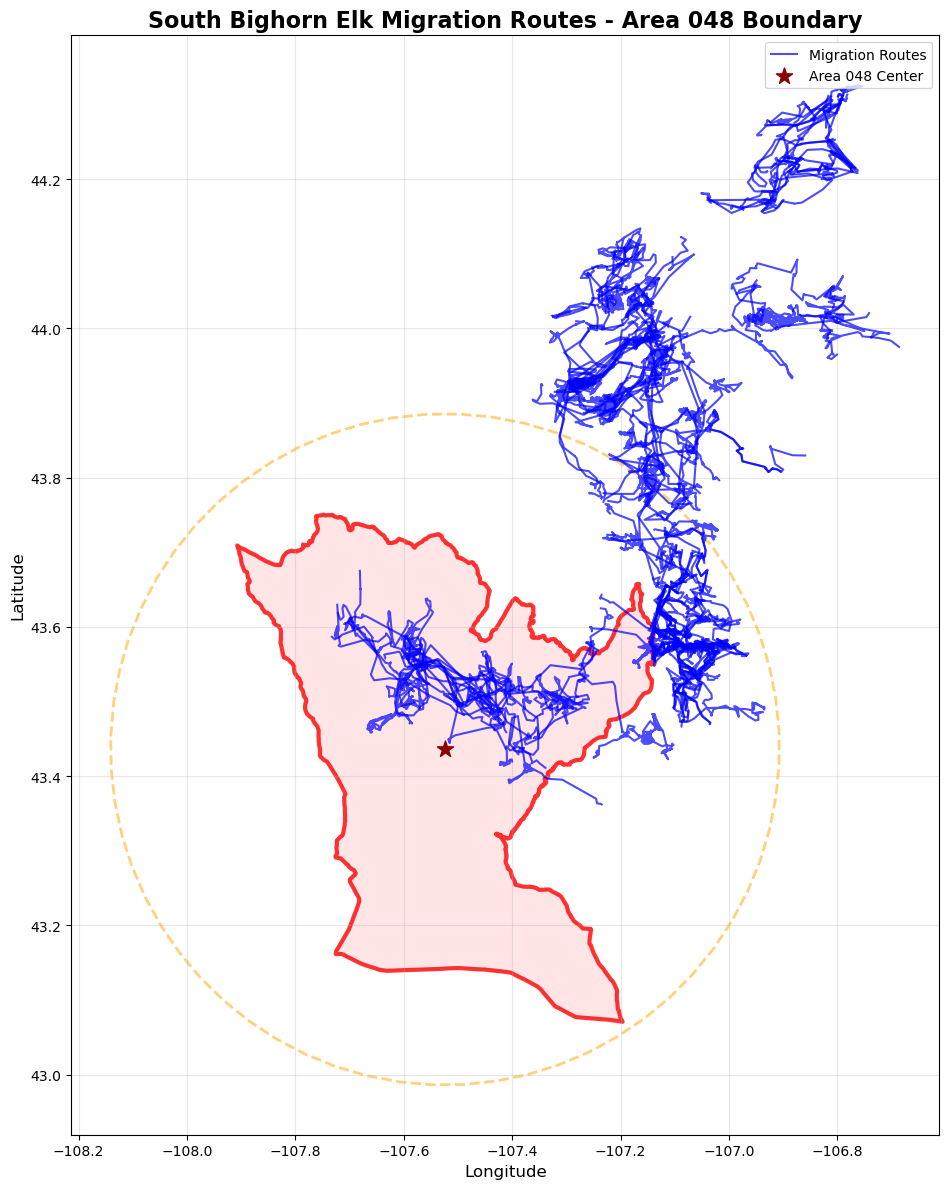


✓ Map saved to data/processed/south_bighorn_routes_area_048.png
  Red polygon = Area 048 boundary
  Points inside polygon are within Area 048


In [67]:
# Plot the migration routes
fig, ax = plt.subplots(figsize=(14, 12))

# Plot routes
gdf_wgs84.plot(ax=ax, linewidth=1.5, alpha=0.7, color='blue', label='Migration Routes')

# Plot Area 048 polygon boundary
if area_048_polygon is not None:
    area_048_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=3, linestyle='-', label='Area 048 Boundary', alpha=0.8)
    # Fill with slight transparency
    area_048_gdf.plot(ax=ax, color='red', alpha=0.1, edgecolor='none')
    
    # Mark center point
    area_048_center_point = gpd.GeoDataFrame(
        [{'name': 'Area 048 Center'}],
        geometry=[Point(area_048_lon, area_048_lat)],
        crs='EPSG:4326'
    )
    area_048_center_point.plot(ax=ax, color='darkred', markersize=150, marker='*', label='Area 048 Center')
else:
    # Fallback: just show center point
    area_048_point = gpd.GeoDataFrame(
        [{'name': 'Area 048'}],
        geometry=[Point(area_048_lon, area_048_lat)],
        crs='EPSG:4326'
    )
    area_048_point.plot(ax=ax, color='red', markersize=200, marker='*', label='Area 048')

# Add a circle showing 50km radius around Area 048 center (for reference)
from shapely.ops import transform
import pyproj

def create_circle(lat, lon, radius_km):
    """Create a circle with radius in km"""
    # Use UTM for accurate distance (Wyoming is in UTM Zone 12N)
    utm = pyproj.Proj(proj='utm', zone=12, ellps='WGS84')
    wgs84 = pyproj.Proj(proj='latlong', ellps='WGS84')
    
    # Convert center to UTM
    center_x, center_y = pyproj.transform(wgs84, utm, lon, lat)
    
    # Create circle in UTM (radius in meters)
    circle = Point(center_x, center_y).buffer(radius_km * 1000)
    
    # Convert back to WGS84
    circle_wgs84 = transform(
        pyproj.Transformer.from_proj(utm, wgs84, always_xy=True).transform,
        circle
    )
    
    return circle_wgs84

circle_50km = create_circle(area_048_lat, area_048_lon, 50)
circle_gdf = gpd.GeoDataFrame([{'radius': '50km'}], geometry=[circle_50km], crs='EPSG:4326')
circle_gdf.plot(ax=ax, color='none', edgecolor='orange', linewidth=2, linestyle='--', label='50km radius', alpha=0.5)

ax.set_title('South Bighorn Elk Migration Routes - Area 048 Boundary', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/south_bighorn_routes_area_048.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Map saved to data/processed/south_bighorn_routes_area_048.png")
if area_048_polygon is not None:
    print("  Red polygon = Area 048 boundary")
    print("  Points inside polygon are within Area 048")


## Step 6: Understand Route Attributes

In [68]:
# Check what information is available about each route
print("Route Attributes:")
print("=" * 60)

# Look for columns that might indicate season, direction, etc.
for col in gdf.columns:
    if col != 'geometry':
        print(f"\n{col}:")
        print(f"  Type: {gdf[col].dtype}")
        print(f"  Unique values: {gdf[col].nunique()}")
        if gdf[col].dtype == 'object':
            print(f"  Sample values: {gdf[col].unique()[:5]}")
        elif gdf[col].dtype in ['int64', 'float64']:
            print(f"  Range: {gdf[col].min()} to {gdf[col].max()}")
            print(f"  Mean: {gdf[col].mean():.2f}")

Route Attributes:

mig:
  Type: object
  Unique values: 93
  Sample values: ['37982_fa17' '37982_fa18' '37982_fa19' '37982_sp17' '37982_sp18']

firstdate:
  Type: object
  Unique values: 80
  Sample values: ['2017-09-14 21:00:00' '2018-11-04 20:00:00' '2019-09-13 19:00:00'
 '2017-05-03 21:00:00' '2018-05-05 21:00:00']

lastdate:
  Type: object
  Unique values: 80
  Sample values: ['2017-09-19 15:00:00' '2018-11-12 14:00:00' '2019-09-27 17:00:00'
 '2017-05-08 15:00:00' '2018-05-18 15:00:00']

id:
  Type: object
  Unique values: 33
  Sample values: ['37982' '37983' '37984' '37985' '37986']

season:
  Type: object
  Unique values: 2
  Sample values: ['fa' 'sp']

year:
  Type: float64
  Unique values: 3
  Range: 2017.0 to 2019.0
  Mean: 2018.05


## Step 7: Prepare Data for PathWild Integration

In [69]:
# Create a simplified dataframe for PathWild
# This will be used to create training examples

pathwild_data = pd.DataFrame({
    'latitude': points_gdf_wgs84['latitude'],
    'longitude': points_gdf_wgs84['longitude'],
    'route_id': points_gdf_wgs84['route_id'],
    'distance_to_area_048_km': points_gdf_wgs84['distance_to_area_048_km']
})

# Add inside_area_048 flag if available
if 'inside_area_048' in points_gdf_wgs84.columns:
    pathwild_data['inside_area_048'] = points_gdf_wgs84['inside_area_048']

# Add any other relevant columns from the original data
for col in gdf.columns:
    if col != 'geometry' and col not in pathwild_data.columns:
        # Map route-level attributes to points
        route_values = gdf[col].to_dict()
        pathwild_data[col] = pathwild_data['route_id'].map(route_values)

print("PathWild-ready dataset:")
print(f"  Shape: {pathwild_data.shape}")
print(f"  Columns: {list(pathwild_data.columns)}")
print(f"\nFirst few rows:")
print(pathwild_data.head())

if 'inside_area_048' in pathwild_data.columns:
    print(f"\nPoints inside Area 048: {pathwild_data['inside_area_048'].sum()} ({(pathwild_data['inside_area_048'].sum() / len(pathwild_data) * 100):.1f}%)")

# Save to CSV for later use
output_file = Path("../data/processed/south_bighorn_points.csv")
output_file.parent.mkdir(parents=True, exist_ok=True)
pathwild_data.to_csv(output_file, index=False)
print(f"\n✓ Saved to {output_file}")


PathWild-ready dataset:
  Shape: (4650, 11)
  Columns: ['latitude', 'longitude', 'route_id', 'distance_to_area_048_km', 'inside_area_048', 'mig', 'firstdate', 'lastdate', 'id', 'season', 'year']

First few rows:
    latitude   longitude  route_id  distance_to_area_048_km  inside_area_048  \
0  44.107875 -107.190964         0                50.134602            False   
1  44.105808 -107.192838         0                49.910345            False   
2  44.101082 -107.192074         0                49.382911            False   
3  44.096356 -107.191310         0                48.855518            False   
4  44.091630 -107.190545         0                48.328166            False   

          mig            firstdate             lastdate     id season    year  
0  37982_fa17  2017-09-14 21:00:00  2017-09-19 15:00:00  37982     fa  2017.0  
1  37982_fa17  2017-09-14 21:00:00  2017-09-19 15:00:00  37982     fa  2017.0  
2  37982_fa17  2017-09-14 21:00:00  2017-09-19 15:00:00  37982     

## Step 8: Summary and Next Steps

In [70]:
print("=" * 60)
print("SOUTH BIGHORN DATASET SUMMARY")
print("=" * 60)
print(f"\nTotal migration routes: {len(gdf)}")
print(f"Total points extracted: {len(points_gdf_wgs84):,}")
print(f"\nGeographic coverage:")
print(f"  Latitude: {points_gdf_wgs84['latitude'].min():.4f}° to {points_gdf_wgs84['latitude'].max():.4f}°")
print(f"  Longitude: {points_gdf_wgs84['longitude'].min():.4f}° to {points_gdf_wgs84['longitude'].max():.4f}°")
print(f"\nProximity to Area 048:")
if 'inside_area_048' in points_gdf_wgs84.columns:
    inside_count = points_gdf_wgs84['inside_area_048'].sum()
    print(f"  Points inside Area 048: {inside_count:,} ({inside_count / len(points_gdf_wgs84) * 100:.1f}%)")
    points_within_50km = (points_gdf_wgs84['distance_to_area_048_km'] <= 50).sum()
    pct_within_50km = points_within_50km / len(points_gdf_wgs84) * 100
    print(f"  Points within 50km: {points_within_50km:,} ({pct_within_50km:.1f}%)")
    if inside_count > 0:
        print(f"  Closest point (outside): {points_gdf_wgs84[~points_gdf_wgs84['inside_area_048']]['distance_to_area_048_km'].min():.2f} km away")
    else:
        print(f"  Closest point: {points_gdf_wgs84['distance_to_area_048_km'].min():.2f} km away")
else:
    points_within_50km = (points_gdf_wgs84['distance_to_area_048_km'] <= 50).sum()
    pct_within_50km = points_within_50km / len(points_gdf_wgs84) * 100
    print(f"  Points within 50km: {points_within_50km:,} ({pct_within_50km:.1f}%)")
    print(f"  Closest point: {points_gdf_wgs84['distance_to_area_048_km'].min():.2f} km away")

if area_048_polygon is not None:
    print(f"\nArea 048 Information:")
    print(f"  Hunt Name: {area_048_gdf['HUNTNAME'].iloc[0]}")
    print(f"  Size: {area_048_gdf['SqMiles'].iloc[0]:.2f} sq miles")
    print(f"  Herd: {area_048_gdf['HERDNAME'].iloc[0]}")

print(f"\nNext steps:")
print("  1. Review the route attributes to understand seasonal patterns")
print("  2. Integrate with DataContextBuilder to add environmental features")
print("  3. Create training dataset with positive examples (route points)")
print("  4. Generate negative examples (random points not on routes)")
print("  5. Train XGBoost model with your heuristics + ML features")


SOUTH BIGHORN DATASET SUMMARY

Total migration routes: 93
Total points extracted: 4,650

Geographic coverage:
  Latitude: 43.3610° to 44.3256°
  Longitude: -107.7342° to -106.6847°

Proximity to Area 048:
  Points inside Area 048: 775 (16.7%)
  Points within 50km: 3,697 (79.5%)
  Closest point (outside): 0.03 km away

Area 048 Information:
  Hunt Name: Upper Nowood
  Size: 930.45 sq miles
  Herd: South Bighorn

Next steps:
  1. Review the route attributes to understand seasonal patterns
  2. Integrate with DataContextBuilder to add environmental features
  3. Create training dataset with positive examples (route points)
  4. Generate negative examples (random points not on routes)
  5. Train XGBoost model with your heuristics + ML features
